In [1]:
!ls

DNN_model  classify.ipynb  infer.py   models-0.75  test_api.py
README.md  fronted	   infer.pyc  models-0.78  utils.py
api_data   gesture	   logs       server.py


In [2]:
import paddle
import paddle.fluid as fluid
import numpy
from __future__ import print_function
try:
    from paddle.fluid.contrib.trainer import *
    from paddle.fluid.contrib.inferencer import *
except ImportError:
    print("Import error")
    from paddle.fluid.trainer import *
    from paddle.fluid.inferencer import *

import numpy as np
import paddle
import paddle.fluid as fluid
import os
from PIL import Image, ImageOps
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

## 1 - 配置网络结构

In [3]:
IMAGE_WIDTH, IMAGE_HEGHT = 64,64

In [4]:
def softmax_regression():
    """
    定义softmax分类器：
        只通过一层简单的以softmax为激活函数的全连接层，可以得到分类的结果
    Args:
        img -- 输入的原始图像数据
    Return:
        predict_image -- 分类的结果
    """
    img = fluid.layers.data(
        name='img', shape =[1,IMAGE_WIDTH,IMAGE_HEGHT],dtype = 'float32')
    predict = fluid.layers.fc(input=img, size=6, act='softmax')
    return predict
 

In [5]:
def multilayer_perceptron():
    """
    定义多层感知机分类器：
        含有两个隐藏层（即全连接层）的多层感知器
        其中两个隐藏层的激活函数均采用 ReLU，输出层的激活函数用 Softmax
    Args:
        img -- 输入的原始图像数据
    Return:
        predict_image -- 分类的结果
    """
    
    img = fluid.layers.data(
        name='img', shape =[1,IMAGE_WIDTH,IMAGE_HEGHT],dtype = 'float32')
    # 第一个全连接层，本层神经元有128个 激活函数为 ReLU 
    hidden1 = fluid.layers.fc(input=img, size=128, act='relu')
    
    # 第二个全连接层，本层神经元有64个 激活函数为 ReLU 
    hidden2 = fluid.layers.fc(input=hidden1, size=64, act='relu')
    
    # 以 softmax 为激活函数的全连接输出层，输出层的大小必须为 10,对应 0-9 这 10 个数字
    predict = fluid.layers.fc(input=hidden2, size=6, act='softmax')
    return predict


In [6]:

def convolutional_neural_network():
    """
    定义卷积神经网络分类器：
        输入的二维图像，经过两个卷积-池化层，使用以softmax为激活函数的全连接层作为输出层
    Args:
        img -- 输入的原始图像数据
    Return:
        predict -- 分类的结果
    """
    img = fluid.layers.data(
        name='img', shape =[1,IMAGE_WIDTH,IMAGE_HEGHT],dtype = 'float32')
    # 第一个卷积-池化层
    conv_pool1 = fluid.nets.simple_img_conv_pool(input=img, 
                                             num_filters=20, 
                                             filter_size=5, 
                                             pool_size=2, 
                                             pool_stride=2, 
                                             pool_padding=0,
                                             act='relu')


    
    # 第二个卷积-池化层
    conv_pool2 = fluid.nets.simple_img_conv_pool(input=conv_pool1, 
                                             num_filters=20, 
                                             filter_size=5, 
                                             pool_size=2, 
                                             pool_stride=2, 
                                             pool_padding=0,
                                             act='relu')
    
    
    
    
    # 以softmax为激活函数的全连接输出层，输出层的大小必须为10,对应0-5这10个数字
    predict = fluid.layers.fc(input=conv_pool2, size=6, act='softmax')
    
    return predict


## 2 - 定义数据加载

In [7]:
def load_image(filename):
    """
    定义读取输入图片的函数：
        读取指定路径下的图片，将其处理成分类网络输入数据对应形式的数据，如数据维度等
    Args:
        file -- 输入图片的文件路径
    Return:
        im -- 分类网络输入数据对应形式的数据
    """
    im = Image.open(filename).convert('L')

    im = im.resize((IMAGE_WIDTH,IMAGE_HEGHT), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, IMAGE_WIDTH,IMAGE_HEGHT).astype(np.float32)
    im = im / 255.0 * 2.0 - 1.0
    return im


In [8]:
def train_data_reader():
    def reader():
        buffer_size = 100
        for dirpath, dirnames, filenames in os.walk('./gesture/train/'):
            for filename in filenames:
                if filename[0] == '.':
                    continue
                label = filename.split('.')[-2][-1]
                images = load_image(os.path.join(dirpath, filename))
                yield images, int(label)
    return reader

In [9]:
def test_data_reader():
    def reader():
        buffer_size = 100
        for dirpath, dirnames, filenames in os.walk('./gesture/test/'):
            label = dirpath.split('/')[-1]
            for filename in filenames:
                if filename[0] == '.':
                    continue
                images = load_image(os.path.join(dirpath, filename))
                yield images, int(label)
    return reader


## 3 - 训练过程

在构建完成分类器后，接下来进入模型的训练过程，一般步骤如下：

- 设置训练场所
- 配置网络结构和优化方法
    - 配置网络结构
    - 定义损失函数 cost
    - 定义优化器 optimizer
- 训练准备
    - 定义输入数据与网络的映射关系
    - 定义文件路径
    - 事件处理函数
    - 定义执行器
        - 初始化网络参数
- 模型训练
    - 定义 reader
    - 定义 trainer 
    - 开始训练


### ** （1）设置训练场所 **

首先进行设置训练使用的设备。在复杂量较低的时候使用 CPU 就可以完成任务，但是对于大规模计算就需要使用 GPU 训练。目前 GPU 训练都是基于 CUDA 工具之上的。
- use_cuda=False 表示不使用 GPU 进行训练

In [10]:
# 设置训练场所
use_cuda = False
place = fluid.CUDAPlace(1) if use_cuda else fluid.CPUPlace()

### ** （2）配置网络结构和优化方法 **
这一阶段，我们关注的是网络拓扑结构的配置和优化方法的配置

** 网络结构 **  
接下来需要配置分类网络的结构，首先通过 layers.data 配置数据输入层，然后配置分类器（代码中提供了三个不同的分类器，每次使用选择其中一个，注释掉其余两个即可）。例如下方代码中选用的是卷积神经网络分类器。  
然后设置损失函数，对于分类问题常常选择交叉熵损失函数。  


In [11]:
def train_func():
    """
    配置网络结构
    Args:
    Return:
        label -- 标签数据
        predict -- 输出层
        cost -- 损失函数
        optimizer -- 优化器
    """
    """
    标签层:
        name=’label’：名称为label,对应输入图片的类别标签
    """
    label = fluid.layers.data(name='label', shape = [1],dtype = 'int64')


    """ 
    选择分类器：
        在此之前已经定义了3种不同的分类器，在下面的代码中,
        我们可以通过保留某种方法的调用语句、注释掉其余两种，以选择特定的分类器
    """
#     predict = softmax_regression()
#     predict = multilayer_perceptron()
    predict = convolutional_neural_network()

    # 损失函数，cross_entropy 函数内部使用交叉熵损失函数
    cost = fluid.layers.cross_entropy(input=predict, label=label)
    avg_cost = fluid.layers.mean(cost)
    acc = fluid.layers.accuracy(input=predict, label=label)
    return [avg_cost, acc]



** optimizer **  

1. 创建优化器 
这里可以尝试采用 Momentum 或 Adam 优化器。 

2. 使用优化器  
- 训练过程在更新权重时采用动量优化器 `Momentum` ，Momentum是为了让目标函数沿梯度方向快速收敛的一种加速学习方法，其中参数 0.9 代表动量优化每次保持前一次速度的 0.9 倍。
- 训练速度（learning_rate）： 迭代的速度，与网络的训练收敛速度有关系。


In [12]:
def optimizer_func():
    # 创建优化器optimizer，下面列举了2种常用的优化器，不同类型优化器选一即可
    # 创建Momentum优化器，并设置学习率(learning_rate)、动量(momentum)
    optimizer = fluid.optimizer.Momentum(learning_rate=0.1 , momentum=0.9)
#     optimizer = fluid.optimizer.SGDOptimizer(learning_rate=1e-3)
#     optimizer = fluid.optimizer.Adagrad(learning_rate=1e-2)
    
    return optimizer

### ** （3）训练准备 **
这个阶段我们关注的是小的相关内容的配置。  
** 定义映射 **  
输入网络的数据要与网络本身应该接受的数据相匹配。在 fluid 中使用 feed_order 的概念来保证输入的数据与网络接受的数据的顺序是一致的。本示例中使用 feed_order = ['x', 'label'] 来告知网络，输入的数据是分为两部分，第一部分是 x 值，第二部分是 label 值。

In [13]:
feed_order = ['img', 'label'] 

** 定义文件路径 **  

在 fluid 中，默认模型的相关数据是需要保存在硬盘上的。也就是说在训练阶段会将训练好的模型保存在硬盘上，在将预测阶段可以直接 load 磁盘上的模型数据，进而做出预测。

In [14]:
params_dirname = "./DNN_model"

** 定义事件处理函数 **  
在 fluid 中，如果是用 trainer 的方式来训练的话，那么，在训练的时候允许开发者自己定义事件回调函数。目前接受的事件有 BeginEpochEvent、EndEpochEvent、BeginStepEvent、EndStepEvent。
 用于输出训练过程中 cost 的变化。

In [15]:

# Plot data
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
plot_cost = Ploter(train_title, test_title)

train_str = []
step = 0
# 事件处理
def event_handler_plot(event):
    global step, train_str
    if isinstance(event, EndStepEvent):
        if event.step % 2 == 0: # 若干个batch,记录cost
            if event.metrics[0] < 10:
                plot_cost.append(train_title, step, event.metrics[0])
                plot_cost.plot()
        if event.step % 20 == 0: # 若干个batch,记录cost
            avg_cost, acc = trainer.test(
            reader=test_reader, feed_order=feed_order)
            if avg_cost < 10:
                plot_cost.append(test_title, step, avg_cost)
                plot_cost.plot()

#             if avg_cost < 0.5:
#                 # 如果准确率达到阈值，则停止训练
#                 print('loss is less than 10.0, stop')
#                 trainer.stop()
            train_str.append("Pass %d, Epoch %d,Train Cost %f, Train Acc %f, Test Cost %f, Test Acc %f,"\
                           %(event.step, event.epoch,
                           event.metrics[0],#train_program返回的第一个参数arg_cost
                           event.metrics[1],#train_program返回的第二个参数acc
                           avg_cost,
                           acc))
            
                            
            
    step += 1
    if isinstance(event, EndEpochEvent):
        # 将参数存储，用于预测使用
        if params_dirname is not None:
            trainer.save_params(params_dirname)
#         avg_cost, acc = trainer.test(reader=test_reader, feed_order=feed_order)
#         print("Test with Epoch %d, avg_cost: %s, acc: %s" % (event.epoch, avg_cost, acc))
        
        
        

** 定义执行器 **   
为了能够运行开发者定义的网络拓扑结构和优化器，需要定义执行器。由执行器来真正的执行参数的初始化和网络的训练过程。

In [16]:
# 创建执行器，palce在程序初始化时设定
exe = fluid.Executor(place)
# 初始化执行器
exe.run(fluid.default_startup_program() )

[]

### （4）** 模型训练 **

** 定义reader **   
网络接受的数据实际上是一个又一个的 mini-batch 。 paddle 框架为开发者准备好了 paddle.batch 函数来提供一个又一个 mini-batch。在实际输入数据的时候，我们希望的是数据顺序不要影响网络是训练，paddle 框架也准备了 paddle.reader.shuffle 函数来打乱输入的顺序。 


In [17]:
# 设置 BATCH_SIZE 的大小
### 练习代码开始处 ### (1行代码) 
BATCH_SIZE = 128
### 练习代码结束处 ###

# 设置训练reader
train_reader = paddle.batch(
    paddle.reader.shuffle(
        train_data_reader(), 
        buf_size=500),
    batch_size=BATCH_SIZE)

#设置测试 reader
test_reader = paddle.batch(
    paddle.reader.shuffle(
        test_data_reader(), 
        buf_size=500),
    batch_size=BATCH_SIZE)

** 定义trainer **   
trainer 负责收集训练需要的相关信息。定义 trainer 时需要提供 3个重要信息：
1. 网络拓扑结构，通过参数 train_func 设定
2. 真实训练的设备，通过参数 place 设定
3. 优化方法，通过参数 optimizer_func 设定

In [18]:
#创建训练器
trainer = Trainer(
    train_func= train_func,
    place= place,
    optimizer_func= optimizer_func)


** 开始训练 **  
在做好了所有的准备工作之后，就开始开始训练了。由于本例使用的是 trainer 的方法，所以可以直接调用 trainer 的 train 方法来执行训练。train 方法主要需要设置3个参数： reader、num_epochs 和 feeder_order。
其中，  
>reader 表示能够持续提供 mini-batch 的数据源  
>num_epochs 表示所有的数据将要训练多少轮次（就是一个数字）  
>feeder_order 表示数据的顺序。

我们注意到，reader 和 feeder_order 在前面的准备过程中已经准备好了。 除了这三个参数外，train 还接受一个 event_handler 参数。这个参数允许开发者自己定义回调函数，用以在训练过程中打印训练相关的信息，甚至在合适的时候停止训练。  
函数的形式如下：
```
trainer.train(
    reader= ,
    num_epochs= ,
    event_handler= ,
    feed_order= )
```

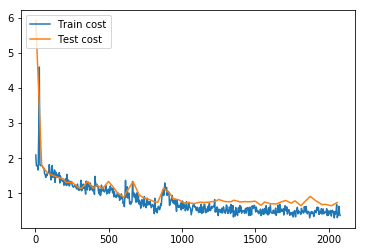

<Figure size 432x288 with 0 Axes>

In [19]:
trainer.train(
    reader=train_reader,
    num_epochs=20,
    event_handler=event_handler_plot,
    feed_order=feed_order)


In [20]:
for train_s in train_str:
    print(train_s)

Pass 0, Epoch 0,Train Cost 2.091950, Train Acc 0.156250, Test Cost 5.928292, Test Acc 0.183333,
Pass 20, Epoch 0,Train Cost 1.791802, Train Acc 0.164062, Test Cost 1.792708, Test Acc 0.175000,
Pass 40, Epoch 0,Train Cost 1.591206, Train Acc 0.328125, Test Cost 1.581969, Test Acc 0.425000,
Pass 0, Epoch 1,Train Cost 1.382789, Train Acc 0.437500, Test Cost 1.535678, Test Acc 0.466667,
Pass 20, Epoch 1,Train Cost 1.455630, Train Acc 0.414062, Test Cost 1.465425, Test Acc 0.341667,
Pass 40, Epoch 1,Train Cost 1.340275, Train Acc 0.406250, Test Cost 1.422728, Test Acc 0.375000,
Pass 0, Epoch 2,Train Cost 1.228244, Train Acc 0.500000, Test Cost 1.309346, Test Acc 0.450000,
Pass 20, Epoch 2,Train Cost 1.240915, Train Acc 0.492188, Test Cost 1.315663, Test Acc 0.541667,
Pass 40, Epoch 2,Train Cost 1.189503, Train Acc 0.554688, Test Cost 1.171998, Test Acc 0.550000,
Pass 0, Epoch 3,Train Cost 1.075830, Train Acc 0.562500, Test Cost 1.142897, Test Acc 0.608333,
Pass 20, Epoch 3,Train Cost 1.0976

In [21]:

# 读取并预处理要预测的图片
cur_dir = os.getcwd()
print(cur_dir)
# img = load_image(cur_dir + '/gesture/test/4/21.jpg')
# 设置训练场所
use_cuda = False
# use_cuda = True
place = fluid.CUDAPlace(1) if use_cuda else fluid.CPUPlace()

inferencer = Inferencer(
#     infer_func=softmax_regression, # uncomment for softmax regression
#     infer_func=multilayer_perceptron, # uncomment for MLP
    infer_func=convolutional_neural_network,  # uncomment for LeNet5
    param_path=params_dirname,
    place=place )
y_test = []
y_pred = []
test_reader = test_data_reader()
total_count = 0
total_acc = 0.0
for img, label in test_reader():
    y_test.append(label)
    results = inferencer.infer({'img': img})
    lab = np.argsort(results)
    y_pred.append(lab[0][0][-1])
    total_count += 1
    if label == lab[0][0][-1]:
        total_acc += 1
print("total_acc: %.2f%%" % (total_acc / total_count * 100) )
# print(lab)
# print("Label of image/infer_3.png is: %d" % lab[0][0][-1])
# print(np.mean(y_test==y_pred))


/paddle_train/GestureRecognition
total_acc: 75.83%
